## Importing Packages and Loading Data

In [4]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'g'

In [5]:
df = pd.read_excel('Data/3transformasidf.xlsx', index_col='Tanggal')
df.head(3)

,Tx,RH_avg,RR,Target,KET
Tanggal,,,,,
2014-01-01,29.10,85.5,14.20,0.0,hujan
2014-02-01,29.35,85.3,7.34,0.0,hujan
2014-03-01,31.40,83.9,7.50,0.0,hujan


In [6]:
y = df['RH_avg']
y

Tanggal
2014-01-01    85.50
2014-02-01    85.30
2014-03-01    83.90
2014-04-01    80.60
2014-05-01    80.40
              ...  
2019-08-01    69.06
2019-09-01    69.50
2019-10-01    69.50
2019-11-01    71.30
2019-12-01    78.10
Name: RH_avg, Length: 72, dtype: float64

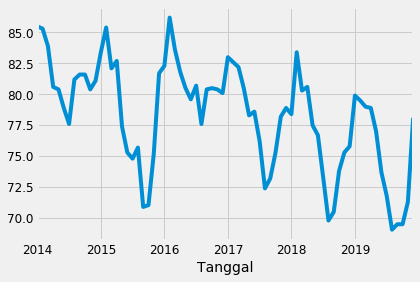

In [7]:
y.plot()
plt.show()

## Cek Stasioneritas

In [9]:
# from statsmodels.tsa.stattools import adfuller
# print("Test-statistic:", adfuller(y.dropna())[0])
# print("p-value:", adfuller(y.dropna())[1])

In [8]:
from statsmodels.tsa.stattools import adfuller

X = y.values
result = adfuller(X)
print('ADF test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF test Statistic: -4.218947
p-value: 0.000612
Critical Values:
	1%: -3.529
	5%: -2.904
	10%: -2.590


## Eksplorasi plot 

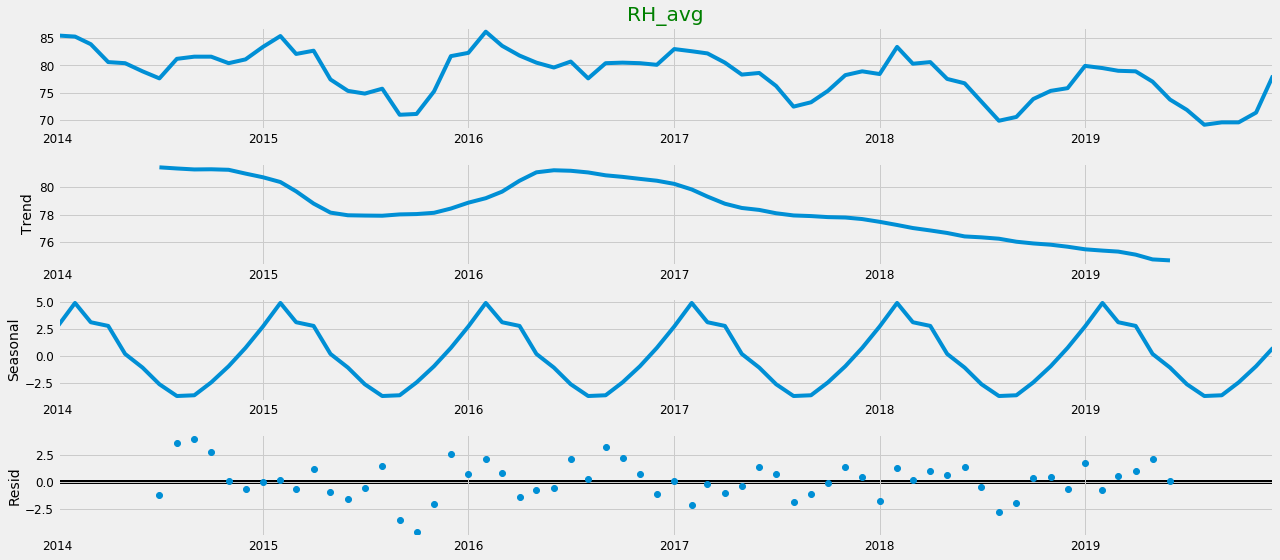

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Seleksi Parameter / Model

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [12]:
warnings.filterwarnings("ignore")
#--------
params=[]
params_s=[]
aics=[]
#--------
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#------            
            params.append(param)
            params_s.append(param_seasonal)
            aics.append(results.aic)
#------  
        except:
            continue
print('Parameter Terbaik: ')
min_ind= aics.index(min(aics))
bestmodel= (params[min_ind], params_s[min_ind])
print('ARIMA', bestmodel,'- AIC:',min(aics))

Parameter Terbaik: 
ARIMA ((0, 1, 1), (1, 1, 1, 12)) - AIC: 199.57832668968763


## Fitting Model

In [13]:
# Param (1,1,1)
# Param seasonal (1,1,1,12)
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

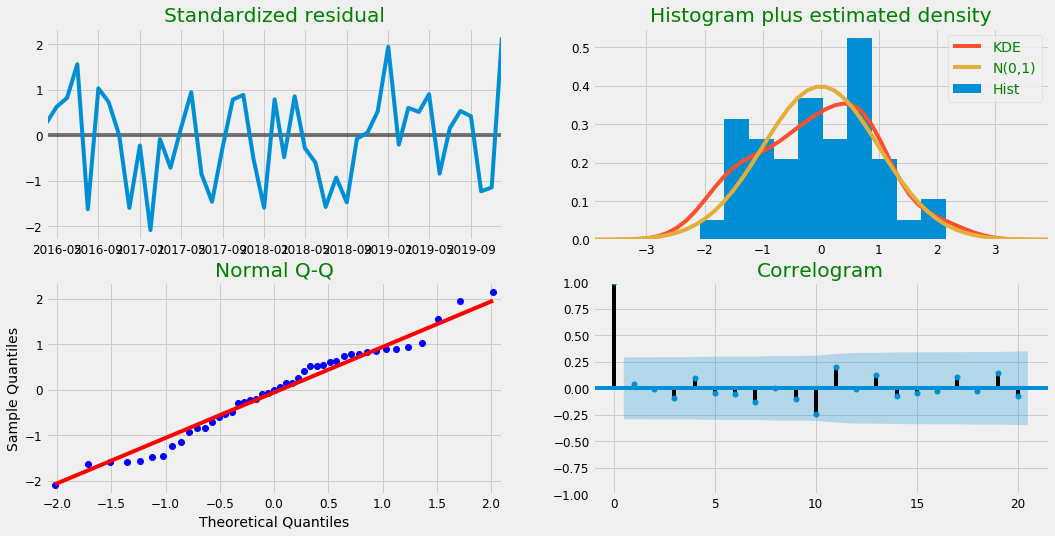

In [14]:
results.plot_diagnostics(figsize=(16, 8), lags=20)
plt.show()

## Validasi Forecasts 

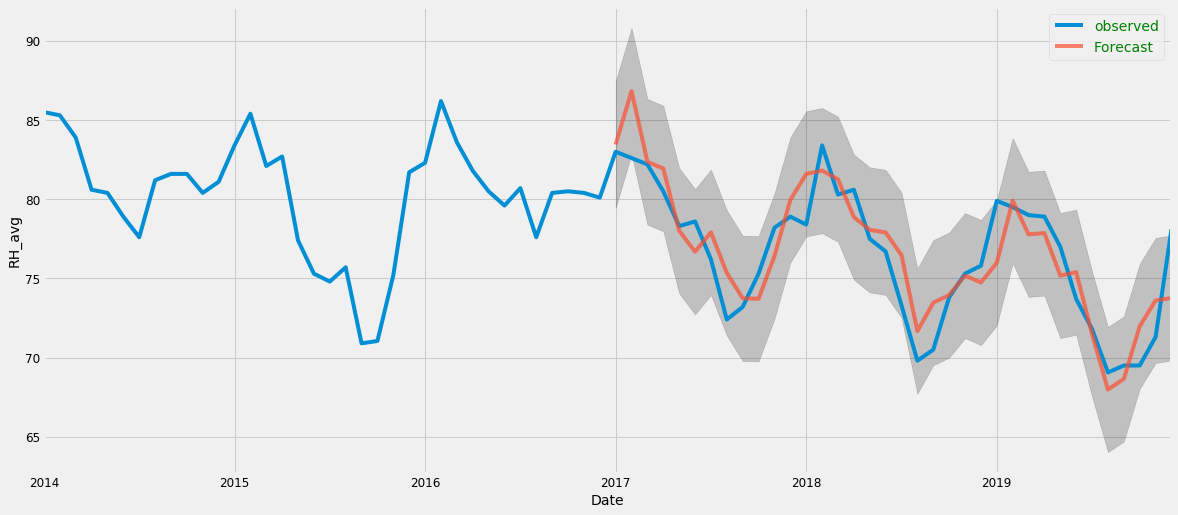

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('RH_avg')
plt.legend()

plt.show()

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3.92


In [17]:
print('The Root MSE of The Forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root MSE of The Forecasts is 1.98


## Visualisasi Forecasts

In [18]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()

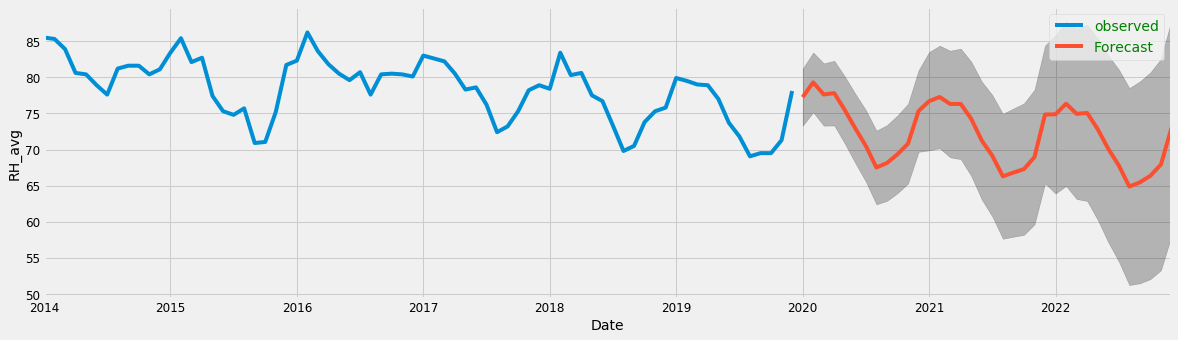

In [19]:
ax = y.plot(label='observed', figsize=(18, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)#alpha for warnanya
ax.set_xlabel('Date')
ax.set_ylabel('RH_avg')

plt.legend()
plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_forecasted.tail(20)

2018-05-01    78.065827
2018-06-01    77.903989
2018-07-01    76.469927
2018-08-01    71.668802
2018-09-01    73.468433
2018-10-01    73.946540
2018-11-01    75.177172
2018-12-01    74.739385
2019-01-01    75.981816
2019-02-01    79.910744
2019-03-01    77.782888
2019-04-01    77.861907
2019-05-01    75.177693
2019-06-01    75.394240
2019-07-01    71.482459
2019-08-01    67.982110
2019-09-01    68.651708
2019-10-01    71.974313
2019-11-01    73.608010
2019-12-01    73.762679
Freq: MS, dtype: float64

In [31]:
# y_truth.head(12)
hasil = pd.DataFrame({'Actual' : y_truth, 'Predicted' : y_forecasted})
hasil.tail(20)

,Actual,Predicted
2018-05-01,77.50,78.065827
2018-06-01,76.70,77.903989
2018-07-01,73.30,76.469927
2018-08-01,69.80,71.668802
2018-09-01,70.50,73.468433
2018-10-01,73.80,73.946540
2018-11-01,75.30,75.177172
2018-12-01,75.80,74.739385
2019-01-01,79.90,75.981816
2019-02-01,79.50,79.910744


In [32]:
pred_ci.head(24)

,lower RH_avg,upper RH_avg
2020-01-01,73.292337,81.194646
2020-02-01,75.160723,83.429860
2020-03-01,73.304243,81.924612
2020-04-01,73.324919,82.282760
2020-05-01,70.821055,80.104106
2020-06-01,68.118136,77.715385
2020-07-01,65.542036,75.443517
2020-08-01,62.415079,72.611719
2020-09-01,62.893499,73.376991
2020-10-01,63.961135,74.723836


In [33]:
forecast = pred_uc.predicted_mean
forecast.head(36)

2020-01-01    77.243491
2020-02-01    79.295291
2020-03-01    77.614427
2020-04-01    77.803839
2020-05-01    75.462581
2020-06-01    72.916760
2020-07-01    70.492776
2020-08-01    67.513399
2020-09-01    68.135245
2020-10-01    69.342486
2020-11-01    70.812105
2020-12-01    75.330066
2021-01-01    76.689733
2021-02-01    77.270854
2021-03-01    76.298315
2021-04-01    76.314127
2021-05-01    74.237552
2021-06-01    71.239347
2021-07-01    69.129668
2021-08-01    66.293878
2021-09-01    66.806646
2021-10-01    67.289739
2021-11-01    68.957533
2021-12-01    74.844344
2022-01-01    74.874668
2022-02-01    76.337956
2022-03-01    74.940538
2022-04-01    75.060482
2022-05-01    72.825140
2022-06-01    70.098292
2022-07-01    67.800081
2022-08-01    64.878162
2022-09-01    65.456359
2022-10-01    66.373822
2022-11-01    67.922744
2022-12-01    72.988469
Freq: MS, dtype: float64

In [35]:
# forecast.to_excel('Data/hasilRHforecast_AIC199.xlsx')